# spaCy pipeline evaluation

This notebook is used to evaluate the entire spaCy pipeline. It compares the predictions of the pipeline with the ground truth author and affiliation data, along with predictions made using other strategies.

Ground truth authors and affiliations were cataloged by hand using SHROOM, and are downloaded as Cocina from SDR by the `preprints:download` task (see README.md). This needs to be run prior to running this notebook.

Article plain texts are extracted from the PDFs using the `preprints:clean` task (see README.md). This also needs to be run prior to running this notebook.

If predictions have already been saved to the `output/spacy` folder, those will be loaded and used. Otherwise, new predictions will be run and saved there.

In [1]:
# set up project root path for imports
import sys
import os
import pathlib
root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
PROJECT_ROOT = pathlib.Path(root)

# make scripts in scripts/ importable and import util functions
sys.path.insert(1, str(PROJECT_ROOT / 'scripts'))
from notebook_utils import get_preprint_text, get_gold_affiliations, load_predictions

# Load the models
import spacy
ner = spacy.load("en_core_web_trf")
ner.disable_pipes("parser")
textcat = spacy.load(PROJECT_ROOT / 'training' / 'textcat_multilabel' / 'model-best')


/Users/budak/.pyenv/versions/3.12.2/envs/ezdeposit/lib/python3.12/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_trf' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/Users/budak/.pyenv/versions/3.12.2/envs/ezdeposit/lib/python3.12/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/budak/.pyenv/versions/3.12.2/envs/ezdeposit/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register

In [2]:
# set up data table with columns for gold and predicted affiliations
import pandas as pd
preprints = pd.read_csv(PROJECT_ROOT / 'assets' / 'preprints.csv')
preprints['gold'] = ''

# add the full text and gold affiliations to the data table
for i, row in preprints.iterrows():
    preprint_id = row['OpenAlex ID']
    preprint_text = get_preprint_text(preprint_id)
    preprint_file = PROJECT_ROOT / "assets" / "preprints" / "pdf" / f"{preprint_id}.pdf"
    preprints.at[i, 'gold'] = get_gold_affiliations(preprint_id)
    preprints.at[i, 'text'] = preprint_text

# limit to only rows where we have gold affiliations
preprints = preprints[preprints['gold'] != '']

In [6]:
from utils import get_affiliation_dict, analyze_pdf_text
from notebook_utils import RESULTS_PATH, load_predictions
from tqdm.notebook import tqdm
import json

# set this and run cell to force re-running predictions
FORCE_RERUN = True

# add a column for predictions
preprints['pred'] = ''

# if we don't have any saved predictions, run prediction for every preprint
spacy_results_path = RESULTS_PATH / "spacy"
predictions = load_predictions(spacy_results_path)
if not predictions or FORCE_RERUN:
    print("No predictions found, running prediction for all preprints")
    for i, row in tqdm(preprints.iterrows(), total=len(preprints), desc="Predicting"):
        preprint_id = row['OpenAlex ID']
        preprint_file = PROJECT_ROOT / "assets" / "preprints" / "txt" / f"{preprint_id}.txt"
        pdf_text = preprint_file.read_text(encoding='utf-8')
        try:
            result = analyze_pdf_text(pdf_text, textcat, ner)
            affiliations = get_affiliation_dict(result)
        except ValueError as e:
            print(f"Error analyzing {preprint_id}: {e}")
            affiliations = {}
        with (spacy_results_path / f"{preprint_id}.json").open(mode="w") as f:
            json.dump(affiliations, f)
    predictions = load_predictions(spacy_results_path)
else:
    print("Using saved predictions")

# set predictions for each preprint in the data table
for i, row in preprints.iterrows():
    preprint_id = row['OpenAlex ID']
    if preprint_id in predictions:
        preprints.at[i, 'pred'] = predictions[preprint_id]

No predictions found, running prediction for all preprints


Predicting:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/budak/.pyenv/versions/3.12.2/envs/ezdeposit/lib/python3.12/site-packages/thinc/shims/pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):


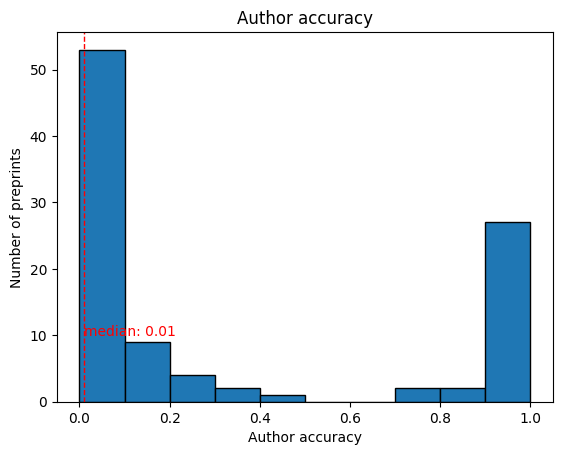

Preprint W3199353954
Authors accuracy: 0.0
Gold: ['Liyun Tu', 'Austin Talbot', 'Neil M. Gallagher', 'David E. Carlson']
Pred: []

Preprint W4385565029
Authors accuracy: 0.0
Gold: ['Rose Wang', 'Dorottya Demszky']
Pred: []

Preprint W3082965143
Authors accuracy: 0.0
Gold: ['Abhinav Parakh', 'Sangryun Lee', 'Mehrdad T. Kiani', 'David Doan', 'Martin Kunz', 'Andrew Doran', 'Seunghwa Ryu', 'X. Wendy Gu']
Pred: []

Preprint W4393028888
Authors accuracy: 0.0
Gold: ['Bronte Mckeown', 'lan Goodall-Halliwell', 'Raven Wallace', 'Louis Chitiz', 'Bridget Mulholland', 'Theodoros Karapanagiotidis', 'Samyogita Hardikar', 'Will Strawson', 'Adam Turnbull', 'Tamara Vanderwal', 'Nerissa Ho', 'Hao-Ting Wang', 'Ting Xu', 'Michael Milham', 'Xiuyi Wang', 'Meichao Zhang', 'Tirso Gonzalez Alam', 'Reinder Vos de Wael', 'Boris Bernhardt', 'Daniel Margulies', 'Jeffrey Wammes', 'Elisabeth Jefferies', 'Robert Leech', 'Jonathan Smallwood']
Pred: []

Preprint W4302282097
Authors accuracy: 0.0
Gold: ['Michael A. Q. Mar

In [8]:
from utils import lev_ratio_list

# calculate some accuracy statistics for authors
for i, row in preprints.iterrows():
    preprints.at[i, 'authors_accuracy'] = lev_ratio_list(list(row['gold'].keys()), list(row['pred'].keys()))

# print a histogram of author accuracy per preprint
%matplotlib inline
import matplotlib.pyplot as plt
author_acc = preprints['authors_accuracy']
author_acc_median = author_acc.median()
plt.hist(author_acc, edgecolor='black')
plt.xlabel('Author accuracy')
plt.ylabel('Number of preprints')
plt.title('Author accuracy')
plt.axvline(author_acc_median, color='r', linestyle='dashed', linewidth=1) 
plt.text(author_acc_median, 10, f'median: {author_acc_median:.2f}', color='r')
plt.show()

# for the preprints with the lowest author accuracy, print the gold and predicted affiliations
worst_preprints = preprints.sort_values(by='authors_accuracy').head(5)
for i, row in worst_preprints.iterrows():
    print("Preprint", row['OpenAlex ID'])
    print("Authors accuracy:", row['authors_accuracy'])
    print("Gold:", list(row['gold'].keys()))
    print("Pred:", list(row['pred'].keys()))
    print()

In [5]:
import statistics

# calculate some accuracy statistics for affiliations
# affiliation accuracy is the mean of the lev ratio of each author's affiliations
for i, row in preprints.iterrows():
    preprints.at[i, 'affiliations_accuracy'] = statistics.mean([
        lev_ratio_list(gold, pred) for gold, pred in zip(row['gold'].values(), row['pred'].values())
    ])

# print a histogram of author accuracy per preprint
%matplotlib inline
import matplotlib.pyplot as plt
affil_acc = preprints['affiliations_accuracy']
affil_acc_median = affil_acc.median()
plt.hist(affil_acc, edgecolor='black')
plt.xlabel('Affiliation accuracy')
plt.ylabel('Number of preprints')
plt.title('Affiliation accuracy')
plt.axvline(affil_acc_median, color='r', linestyle='dashed', linewidth=1)
plt.text(affil_acc_median, 10, f'median: {affil_acc_median:.2f}', color='r')
plt.show()

# for the preprints with the lowest affiliation accuracy, print the gold and predicted affiliations
worst_preprints = preprints.sort_values(by='affiliations_accuracy').head(5)
for i, row in worst_preprints.iterrows():
    print(f"{row['OpenAlex ID']} ({row['OpenAlex Title']})")
    print("Affiliations accuracy:", row['affiliations_accuracy'])
    print("Gold:", list(row['gold'].values()))
    print("Pred:", list(row['pred'].values()))
    print()


StatisticsError: mean requires at least one data point